# ASWS Dashboard Development Notebook

1) connect to the server
2) get a list of asws that belong to the bc gov
3) make a dataframe out of all these stations that includes their location identifier and name
4) loop through each station and request each parameter, building a dataframe for each station. derive required variables (min/max etc). Also store pc pipe height, snow depth offset
5) run a series of checks on data that highlight parameters that require further investigation
7) plot all findings in alphabetical order

In [51]:
import pandas as pd
import numpy as np
import os
import requests
import datetime
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import json

import snowlib.snowlib as sl

# show full pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# orient in time
ts_now = pd.Timestamp.utcnow().floor("1h")
lastweek = (ts_now - pd.Timedelta(days=7)).strftime("%Y-%m-%d %H:%M")
now = ts_now.strftime("%Y-%m-%d %H:%M")
local_now = pd.Timestamp.now().floor("1h").strftime("%Y-%m-%d-%H%M")

# where to save the figures
save_dir = "A:\\Snow\\Operations ORCS\\Field Operations\\Station Health"

## Connect to the Server

In [2]:
# initialize a session on the aquarius API
session = sl.aq_api_client()
session.connect()

# get all station descriptions
loc_list = session.publish.get("/GetLocationDescriptionList")
loc_json = loc_list.json()

## Get a List of ASWS that Belong to the BC Government

In [3]:
# filter down to ASWS stations tagged with "BC Gov."
asws_stations = [
    dictionary for dictionary in loc_json['LocationDescriptions']
    if (("BC Gov." in [tag["Key"] for tag in dictionary['Tags']]) 
        and (dictionary['PrimaryFolder'] == "Locations.SNOW.Snow Weather Stations"))
]

# convert to pandas
asws_stations = pd.DataFrame.from_dict(asws_stations)

## Loop through each station and request each parameter

In [4]:
def get_param(name):
    '''
    gets a parameter from the API, if it exists 
    
    Inputs 
    name e.g. "TA.Working@1A101P"
    
    Returns 
    None
    '''
    if name in params:
        param = session.publish.get(f"/GetTimeSeriesRawData?TimeSeriesUniqueId={params[name]}&QueryFrom={lastweek}&QueryTo={now}").json()
        timestamp = [param["Points"][i]["Timestamp"] for i in range(len(param["Points"]))]
        value = [param["Points"][i]["Value"]["Numeric"] for i in range(len(param["Points"]))]
        pstore.append(pd.DataFrame({param["Parameter"]:value}, index=pd.to_datetime(timestamp, utc=True)))  
        
    return None

In [5]:
def get_pc_height(identifier):
    pc_thres = [tsd["Thresholds"] for tsd in ts_json["TimeSeriesDescriptions"] if tsd["Identifier"] == f'PC.Working@{identifier}']
    if len(pc_thres) > 0:
        pc_thres = pc_thres[0][0]
        if (pc_thres["Name"] == "PC height"):
            pch = pc_thres["Periods"][0]["ReferenceValue"]
        else:
            pch = -1
    else:
        pch = -1
    return pch

In [6]:
asws_data = {}
asws_pch = {}
for index, row in asws_stations.iterrows():
    print(row["Identifier"], row["Name"])
    ts_json = session.publish.get(f"/GetTimeSeriesDescriptionList?LocationIdentifier={row['Identifier']}").json()
    params = {tsd["Identifier"]:tsd["UniqueId"] for tsd in ts_json["TimeSeriesDescriptions"]}
    pstore = []
    
    # pick out the params we want plotted
    get_param(f"TA.Working@{row["Identifier"]}")
    get_param(f"TA2.Working@{row["Identifier"]}")
    get_param(f"RH.Working@{row["Identifier"]}")
    get_param(f"PA.Working@{row["Identifier"]}")
    get_param(f"PC.Working@{row["Identifier"]}")
    get_param(f"PC2.Working@{row["Identifier"]}")
    get_param(f"SD.Working@{row["Identifier"]}")
    get_param(f"SW.Working@{row["Identifier"]}")
    get_param(f"Bvolt.Telemetry@{row["Identifier"]}")
    get_param(f"VS.Telemetry@{row["Identifier"]}")
    get_param(f"YB.Telemetry@{row["Identifier"]}")
    get_param(f"SignalStrength.Telemetry@{row["Identifier"]}")

    # deternime the pc pipe height and save it in another dataframe
    asws_pch[row["Name"]] = get_pc_height(row["Identifier"])
    
    # add the station to the list if non-empty
    if len(pstore) > 0:
        station_data = pd.concat(pstore, axis=1)
        station_data[station_data > 99998] = np.nan # purge 99999s
        asws_data[row["Name"]] = station_data  


1A01P Yellowhead Lake
1A02P McBride Upper
1A03P Barkerville
1A05P Longworth Upper
1A14P Hedrick Lake
1A15P Knudsen Lake
1A17P Revolution Creek
1A19P Dome Mountain
1C20P Boss Mountain Mine
1C29P Shovelnose Mountain
1C41P Yanks Peak
1D06P Tenquille Lake
1D17P Chilliwack River
1D19P Spuzzum
1E02P Mount Cook
1E08P Azure River
1E10P Kostal Lake
1E14P Cook Creek
1F03P Park Mountain
1F04P Enderby
1F04P2 Enderby Tower 2
1F06P Celista
2D05P Gray Creek Lower
2D10P Gray Creek Upper
2D14P Redfish Creek
2E07P Grano Creek
2F01AP Trout Creek West
2F05P Mission Creek
2F08P Greyback Reservoir
2F10P Silver Star Mountain
2F18P Brenda Mine
2F19P Oyama Lake
2G03P Blackwall Peak
3A22P Nostetuko River
3A24P Mosley Creek Upper
3A25P Squamish River Upper
3A28P Tetrahedron
3B23P Jump Creek
3B24P Heather Mountain Upper
3B25P Malaview Test ASWS
3B26P Mount Arrowsmith
3C08P Burnt Bridge Creek
4B12P Granduc Mine
4B15P Lu Lake
4B16P Shedin Creek
4B17P Tsai Creek
4B18P Cedar-Kiteen
4C09P Deadwood River
4D11P Kinaskan

## Flag Parameters with Suspected Errors

put these functions in their own library once sufficiently complete

In [7]:
def flag_complete(var, threshold=95):
    """
    returns true if the number of non-NaN entries exceeds a threshold (default 95%)
    """
    completeness = (len(var) - var.isna().sum()) / len(var) * 100 # %
    if completeness < threshold:
        flag = True
    else: 
        flag = False
    return flag

In [8]:
def flag_transmission(var, threshold="1D"):
    """
    returns true if the last transmission occurred longer than a threshold time (default 1 day)
    assumes UTC time
    """
    ts_now = pd.Timestamp.utcnow().floor("1h")
    if ts_now - var.index[-1] > pd.Timedelta(threshold):
        flag = True
    else:
        flag = False
    return flag

In [9]:
def flag_ta(ta):
    return False

In [10]:
def flag_rh(rh):
    return False

In [11]:
def flag_pa(pa):
    return False

In [12]:
def flag_pc(pc):
    return False

In [13]:
def flag_ta(ta):
    return False

In [14]:
def flag_sd(sd):
    """
    audits snow depth data and returns True if flagged data detected
    """
    # check if any snow depth data are < 0
    if (sd < 0).any():
        flag = True
    
    # default value false
    else:
        flag = False
    return flag

In [15]:
def flag_sw(sw):
    return False

In [16]:
def flag_vb(vb):
    """
    audits battery voltage data and returns True if flagged data detected
    """
    # voltage less than 12 or greater than 20
    if (vb < 12).any():
        flag = True
    elif (vb > 20).any():
        flag = True
    else:
        flag = False
    return flag

In [17]:
def flag_vs(vs):
    return False

In [18]:
def flag_yb(yb):
    return False

In [31]:
def flag_tx(tx):
    """
    audits transmission strength data and returns True if flagged data detected
    """
    if (tx < 37).any():
        flag = True
    elif (tx > 41).any():
        flag = True
    else:
        flag = False
    return flag

## Make a Plot

In [32]:
def plot_param(station_data, param, offset, unit, flag, alias=False):
    """
    adds a parameter to the plot if defined
    """
    if (param in station_data.columns) and (len(station_data[param])) > 0:
        # implement the check function
        if flag(station_data[param]):
            color = "firebrick"
        else:
            color="black"

        # variable name or alias
        if alias:
            name = alias
        else:
            name = param
        ax[i].text(offset, 0.8, name, weight="bold", color=color)

        # latest
        latest = f"{(station_data[param].iloc[-1])} {unit}"
        ax[i].text(offset, 0.6, latest)
        
        # range
        the_range = f"{station_data[param].min()} - {station_data[param].max()}"
        ax[i].text(offset, 0.4, the_range)
        
        # completeness
        if flag_complete(station_data[param]):
            color = "firebrick"
        else:
            color = "black"
        completeness = f"{len(station_data) - station_data[param].isna().sum()}/{len(pd.date_range(lastweek, now, freq="h"))}"
        ax[i].text(offset, 0.2, completeness, color=color)

        offset += 0.1 # shift the next column over
        
    return offset

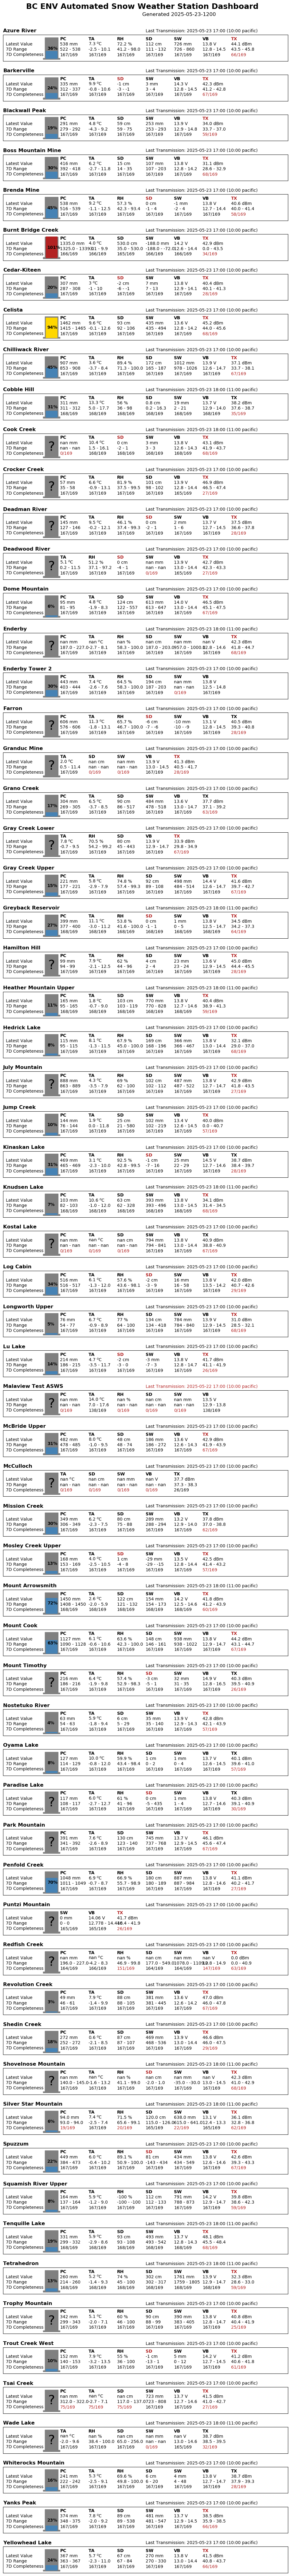

In [67]:
plt.style.use("_classic_test_patch")
fig, ax = plt.subplots(len(asws_data), 1, figsize=(10, len(asws_data)* 1.3))
fig.tight_layout()
fig.suptitle("BC ENV Automated Snow Weather Station Dashboard", y=1.01, weight="bold", fontsize=18)
fig.text(0.5, 1.005, f"Generated {local_now}", fontsize=12)


station_names = sorted(list(asws_data.keys())) # sort alphabetically by name
for i, name in enumerate(station_names):
    
    # title etc
    ax[i].set_title(name, loc="left", weight="bold")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].text(0.01, 0.6, "Latest Value")
    ax[i].text(0.01, 0.4, "7D Range")
    ax[i].text(0.01, 0.2, "7D Completeness")

    # last transmission
    if flag_transmission(asws_data[name]):
        color = "firebrick"
    else:
        color = "black"
    last_trans = asws_data[name].index[-1]
    last_trans_pacific = last_trans.tz_convert("America/Vancouver").strftime("%H:%M")
    ax[i].text(0.5, 1.1, f"Last Transmission: {last_trans.strftime("%Y-%m-%d %H:%M")} ({last_trans_pacific} pacific)", color=color)

    # PC graphic
    offset = 0.25
    pch = asws_pch[name]
    bgnd = Rectangle((0.147, 0.1),0.046,0.8,color="grey")
    base = Rectangle((0.14, 0.07),0.06,0.05,color="grey")
    bgnd = ax[i].add_patch(bgnd)
    bgnd = ax[i].add_patch(base)
    
    # plot a big question mark if no data to display (i.e. no column header, no data, no pipe height defined)
    if ("PC" not in asws_data[name].columns) or (len(asws_data[name]["PC"]) == 0) or (pch < 0) or np.isnan(asws_data[name]["PC"].iloc[-1]): 
        ax[i].text(0.158, 0.35, "?", fontsize=30) 
    else:
        # pc pipe % full
        ax[i].text(0.155, 0.44, f"{round(asws_data[name]["PC"].iloc[-1] / pch * 100)}%", weight="bold")
        
        # blue of pipe is less than 80% full
        if asws_data[name]["PC"].iloc[-1] < pch * 0.8:
            pc_color = "steelblue"
            pipe = Rectangle((0.15, 0.1),0.04,asws_data[name]["PC"].iloc[-1] / pch * 0.8, color="steelblue")
            ax[i].add_patch(pipe)
            
        # yellow if 80 - 95% full
        elif asws_data[name]["PC"].iloc[-1] < pch * 0.95: 
            pipe = Rectangle((0.15, 0.1),0.04,asws_data[name]["PC"].iloc[-1] / pch * 0.8, color="gold")
            ax[i].add_patch(pipe)
            
        # red if > 95% full
        elif asws_data[name]["PC"].iloc[-1] >= pch * 0.95:
            pipe = Rectangle((0.15, 0.1),0.04,asws_data[name]["PC"].iloc[-1] / pch * 0.8, color="firebrick")
            ax[i].add_patch(pipe)

    # plot each variable
    offset = plot_param(asws_data[name], "PC", 0.2, "mm", flag_pc)
    offset = plot_param(asws_data[name], "PC2", offset, "mm",flag_pc)
    offset = plot_param(asws_data[name], "TA", offset, "$^o$C", flag_ta)
    offset = plot_param(asws_data[name], "TA2", offset, "$^o$C", flag_ta)
    offset = plot_param(asws_data[name], "RH", offset, "%", flag_rh)
    offset = plot_param(asws_data[name], "PA", offset, "hPa", flag_pa)
    offset = plot_param(asws_data[name], "SD", offset, "cm", flag_sd)
    offset = plot_param(asws_data[name], "SW", offset, "mm", flag_sw)
    offset = plot_param(asws_data[name], "Bvolt", offset, "V", flag_vb, alias="VB")
    offset = plot_param(asws_data[name], "SignalStrength", offset, "dBm", flag_tx, alias="TX")

fig.savefig(f"{save_dir}\\dashboard_{local_now}.pdf", format="pdf")